In [41]:
import os
import pandas as pd
import boto3
from datetime import datetime, timedelta

import importlib
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, FloatSlider
import order_book.transformation
from order_book.simulation import *
from order_book.transformation import *
from order_book.loader import *
import awswrangler as wr

import ml_model
from ml_model.test_model import *
from ml_model.seq2seq import *

from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
boto3.setup_default_session(profile_name="data")

%reload_ext autoreload
%autoreload 2

In [ ]:
"""
Ideas:
Include ob of hourly and all 4 quarter hourly products




Model Input:
Ob Vector:
Information: TtD, DoW, Price, Spread
Bids: [0% - 2%], [2% - 5%],[5% - 10%], [10% - 20%], [20% - 50%], [50% - infty]
Asks: [0% - 2%], [2% - 5%],[5% - 10%], [10% - 20%], [20% - 50%], [50% - infty]








"""

In [85]:
dl = DataLoader()

start = datetime(2024, 1, 4, 20, 15)
end = datetime(2024, 1, 4, 21, 0)

order_data = dl.get_raw_product_orders(start, end)

KeyError: 0

In [84]:
order_data["DeliveryArea"].unique()

array(['DE2', 'DE3', 'DE4', 'DE1'], dtype=object)

### Data Transformation

In [43]:
num_orders = 5
num_obs = 5
horizons = 4
ticks = 1000

In [44]:
ob_series = to_ob_series_by_ticks(order_data, num_orders=num_orders, ticks=ticks)

In [45]:
price_trends = get_price_trends(ob_series, horizons=horizons)

/Users/henryhenryson/Documents/TUM/semester8/entrix/ml-w-lobs/order_book/transformation.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trends)


In [46]:
ob_vectors, change_vectors = ob_series_to_vectors(ob_series)

In [66]:
encoder_input, decoder_output = vecs_to_model_input(change_vectors, num_obs, price_trends, horizons)
decoder_input = np.array([np.array([decoder_output[0][0]]) if i == 0 else np.array([decoder_output[i-1][0]]) for i in range(len(encoder_input))])

In [67]:
decoder_input.shape

(103, 1, 3)

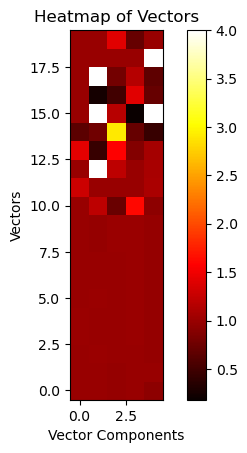

In [68]:
plt.imshow(x_data[2].T, cmap='hot', interpolation='nearest', origin='lower', vmax=4)

# Adding color bar to show the scale
plt.colorbar()

# Adding labels
plt.xlabel('Vector Components')
plt.ylabel('Vectors')
plt.title('Heatmap of Vectors')

# Display the heatmap
plt.show()

### Training

In [69]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#### Seq2Seq

In [78]:
n_hidden = 16

seq2seq_model = get_seq2seq_model(
    num_obs = num_obs, 
    num_orders=num_orders, 
    horizons=horizons, 
    latent_dim=n_hidden)

seq2seq_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

seq2seq_model.summary()

2024-05-28 12:05:43.369779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-28 12:05:43.371355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-28 12:05:43.372434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 5, 20)]      0           []                               
                                                                                                  
 lstm_32 (LSTM)                 [(None, 16),         2368        ['input_33[0][0]']               
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 input_34 (InputLayer)          [(None, 1, 3)]       0           []                               
                                                                                            

2024-05-28 12:05:44.136763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-28 12:05:44.138175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-28 12:05:44.139219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [79]:
epochs = 50
batch_size = 64
val_split = 100

encoder_input_train = encoder_input[1:100]
decoder_input_train = decoder_input[1:100]
decoder_output_train = decoder_output[1:100]

enc_in_val = encoder_input[100:]
dec_in_val = decoder_input[100:]
dec_out_val = decoder_output[100:]


seq2seq_model.fit(
    [encoder_input_train, decoder_input_train], decoder_output_train,
    batch_size=batch_size,
    epochs=epochs, verbose=1,
    validation_data = ([enc_in_val, dec_in_val], dec_out_val)
)

Epoch 1/50
2/2 [==============================] - 0s 134ms/step - loss: 1.1250 - accuracy: 0.3157 - val_loss: 1.0913 - val_accuracy: 0.2500
Epoch 2/50
2/2 [==============================] - 0s 105ms/step - loss: 1.1086 - accuracy: 0.3207 - val_loss: 1.0612 - val_accuracy: 0.3333
Epoch 3/50
2/2 [==============================] - 0s 106ms/step - loss: 1.1004 - accuracy: 0.3687 - val_loss: 1.0496 - val_accuracy: 0.4167
Epoch 4/50
2/2 [==============================] - 0s 106ms/step - loss: 1.0937 - accuracy: 0.3838 - val_loss: 1.0367 - val_accuracy: 0.4167
Epoch 5/50
2/2 [==============================] - 0s 105ms/step - loss: 1.0889 - accuracy: 0.4141 - val_loss: 1.0313 - val_accuracy: 0.4167
Epoch 6/50
2/2 [==============================] - 0s 104ms/step - loss: 1.0853 - accuracy: 0.4141 - val_loss: 1.0236 - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 0s 105ms/step - loss: 1.0817 - accuracy: 0.4217 - val_loss: 1.0130 - val_accuracy: 0.5000
Epoch 8/50
2/2 [====

In [16]:
model = get_model(num_obs = num_obs, num_orders=num_orders, horizons=horizons)

optimizer = Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)



split_train_val = 100


x_train = x_data[:100]
y_train = y_data[:100]


model.fit(
    x_train, y_train,
    epochs=epochs, verbose=1,
    validation_data=(x_train, y_train)
)

Epoch 1/15


/opt/anaconda3/envs/winfo/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 3s 641ms/step - loss: 3.2198 - accuracy: 0.3775 - val_loss: 2.0352 - val_accuracy: 0.4475
Epoch 2/15
4/4 [==============================] - 2s 613ms/step - loss: 1.6347 - accuracy: 0.4375 - val_loss: 1.0269 - val_accuracy: 0.5175
Epoch 3/15
4/4 [==============================] - 2s 568ms/step - loss: 0.9780 - accuracy: 0.5600 - val_loss: 0.8390 - val_accuracy: 0.5975
Epoch 4/15
4/4 [==============================] - 2s 620ms/step - loss: 0.8202 - accuracy: 0.6175 - val_loss: 0.7393 - val_accuracy: 0.6925
Epoch 5/15
4/4 [==============================] - 2s 606ms/step - loss: 0.7311 - accuracy: 0.6925 - val_loss: 0.6661 - val_accuracy: 0.7775
Epoch 6/15
4/4 [==============================] - 2s 608ms/step - loss: 0.6461 - accuracy: 0.7650 - val_loss: 0.5532 - val_accuracy: 0.8200
Epoch 7/15
4/4 [==============================] - 2s 616ms/step - loss: 0.5352 - accuracy: 0.8500 - val_loss: 0.4381 - val_accuracy: 0.9375
Epoch 8/15
4/4 [===============